In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
import os
from PIL import Image
import io


In [2]:
!pip install kaggle


# Upload the kaggle.json file (this step requires manual upload in Colab)
from google.colab import files
files.upload()    #Upload the kaggle.json file provided in the zip folder

# Move kaggle.json to the right place
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
dataset_dir = '/content/datasets/stanford_cars'
train_dataset_path = os.path.join(dataset_dir, 'cars_train')
test_dataset_path = os.path.join(dataset_dir, 'cars_test')

# Create directories for the dataset
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(train_dataset_path, exist_ok=True)
os.makedirs(test_dataset_path, exist_ok=True)

# Download the Stanford Cars dataset from Kaggle
!kaggle datasets download -d jessicali9530/stanford-cars-dataset -p {dataset_dir}

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/stanford-cars-dataset
License(s): other
stanford-cars-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile
zip_file_path = os.path.join(dataset_dir, 'stanford-cars-dataset.zip')      #unzips the downloaded datasets
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(path=dataset_dir)
    print(f'Extracted stanford-cars-dataset.zip successfully.')
except zipfile.BadZipFile as e:
    print(f'Error extracting stanford-cars-dataset.zip: {e}')

Extracted stanford-cars-dataset.zip successfully.


In [2]:
def load_images(image_dir, image_size=(64, 64)):
    image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
    images = []
    for file in image_files:
        img = tf.keras.preprocessing.image.load_img(file, target_size=image_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
    images = np.array(images) / 255.0
    return images

# Directory containing images
image_dir = '/content/datasets/stanford_cars/cars_train/cars_train'
images = load_images(image_dir)

In [3]:
# Convert images to tf.data.Dataset
dataset = tf.data.Dataset.from_tensor_slices(images)
dataset = dataset.shuffle(buffer_size=1000).batch(64).prefetch(1)

# Define the modified generator
def build_modified_generator(input_shape=(64, 64, 3)):
    model = Sequential()
    model.add(InputLayer(input_shape=input_shape))
    model.add(Conv2D(128, kernel_size=3, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, kernel_size=3, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(128, kernel_size=3, padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Conv2D(3, kernel_size=3, padding='same', activation='sigmoid'))
    return model

modified_generator = build_modified_generator()
modified_generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 3)           │           3,459 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 302,211 (1.15 MB)

 Trainable params: 302,211 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, 5, input_shape=(64, 64, 3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 60, 60, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 52, 52, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 52, 52, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 48, 48, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 48, 48, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 48, 48, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 589824)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 589824)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         589,825 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,667,905 (6.36 MB)

 Trainable params: 1,667,905 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

# Define the GAN model
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(real_images, training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(real_images, training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss": total_d_loss, "g_loss": total_g_loss}

In [ ]:
gan = GAN(generator=modified_generator, discriminator=discriminator)
gan.compile(g_opt=g_opt, d_opt=d_opt, g_loss=g_loss, d_loss=d_loss)

# Train the GAN (example)
gan.fit(dataset, epochs=450)  # Adjust epochs as needed

# Save the models after training
modified_generator.save('generator_model.h5')
discriminator.save('discriminator_model.h5')

Saving car.jfif to car (1).jfif


<ipython-input-8-96efc6c4d04a>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(target_size, Image.ANTIALIAS)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


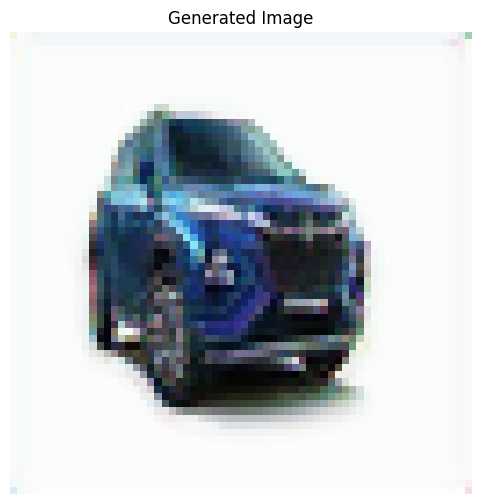

In [8]:

from google.colab import files
# Function to upload an image
def upload_image():
    uploaded = files.upload()
    for filename in uploaded.keys():
        img_path = filename
        break
    return img_path

# Function to preprocess the uploaded image
def preprocess_image(img_path, target_size=(64, 64)):
    img = Image.open(img_path).convert('RGB')
    img = img.resize(target_size, Image.ANTIALIAS)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalize the image
    return img_array

# Function to generate and display image using the trained generator
def generate_and_display_image(generator, img_array):
    generated_image = generator.predict(img_array)

    # Plot the generated image
    plt.figure(figsize=(6, 6))
    plt.imshow(np.squeeze(generated_image))
    plt.title("Generated Image")
    plt.axis('off')
    plt.show()

# Main testing function
def test_generator(generator):
    # Upload an image
    img_path = upload_image()

    # Preprocess the image
    img_array = preprocess_image(img_path)

    # Generate and display image
    generate_and_display_image(generator, img_array)

# Load your trained generator model
from tensorflow.keras.models import load_model
generator = load_model('generator_model.h5')

# Run the test
test_generator(generator)
